In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [2]:
# Configuration
TABLE_TYPE = 'domestic'
LEAGUES = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
SEASON = '2526'
MIN_MINUTES = 250

LEIPZIG_COLORS = {
    'primary': '#FF6B6B',
    'secondary': '#FFFFFF'
}

PLAYER_CONFIG = {
    'name': 'Yan Diomandé',
    'search': 'Yan Diomand',
    'team': 'RB Leipzig'
}

SAVE_PATH_BASE = "./diomande_radar/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
db = get_db_manager()

league_list_str = "', '".join(LEAGUES)
query = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
df_raw.head()

2026-01-02 17:19:08,064 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-02 17:19:08,403 - database.connection - INFO - Database connection successful


Extraídos: 2281 registros, 10 columnas


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,4297cac0772af3c8,Ben White,Arsenal,ENG-Premier League,2526,DF,ENG,None,"{'FK': '0', 'OG': '0', 'Crs': '1', 'Fld': '0',...",{}
1,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2526,FW,ENG,None,"{'FK': '2', 'OG': '0', 'Crs': '43', 'Fld': '23...",{}
2,278433de9fa4c551,Christian Nørgaard,Arsenal,ENG-Premier League,2526,MF,DEN,None,"{'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '0',...",{}
3,e94c51c954d24b45,Cristhian Mosquera,Arsenal,ENG-Premier League,2526,DF,ESP,None,"{'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '1',...",{}
4,57f809b3be3768e0,David Raya,Arsenal,ENG-Premier League,2526,GK,ESP,None,"{'CS': '7', 'FK': '0', 'OG': '0', '/90': '-0.1...",{}


In [4]:
# Filtrar por minutos + posición FW
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('FW', case=False, na=False))
].copy()

print(f"Filtro {MIN_MINUTES}+ min + FW: {df_filtered.shape[0]} jugadores")

Filtro 250+ min + FW: 511 jugadores


In [5]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 0 métricas


In [6]:
exclude_normalization = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id',
    'Touches_Touches'
}

# Per100touches FBref
fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

# Per100touches Understat
understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"Per100touches: {fbref_per100.shape[1]} + {understat_per100.shape[1]}")

all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per100, understat_per100], axis=1)

Per100touches: 153 + 0


In [7]:
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Métricas totales: 338
Percentiles totales: 338


In [8]:
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 511 filas, 682 columnas
Limpieza completada: 680 columnas finales


In [9]:
search_pattern = PLAYER_CONFIG['search']

search_results = df_filtered[
    df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)
]

print(f"DIOMANDÉ SEARCH - '{search_pattern}':")
print("=" * 60)

if len(search_results) > 0:
    for _, p in search_results.iterrows():
        minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
        print(f"{p['unique_player_id']} - {p['player_name']}")
        print(f"  Team: {p['team']} | League: {p['league']}")
        print(f"  Position: {p['position']} | Minutes: {minutes}")
        print()
    
    diomande_id = search_results.iloc[0]['unique_player_id']
    diomande_name = search_results.iloc[0]['player_name']
    diomande_team = search_results.iloc[0]['team']
    
    print(f"✓ ASSIGNED: {diomande_name} ({diomande_team}) -> {diomande_id}")
else:
    print("✗ DIOMANDÉ NOT FOUND")
    diomande_id = None

DIOMANDÉ SEARCH - 'Yan Diomand':
662a6ce71fd7717a - Yan Diomandé
  Team: RB Leipzig | League: GER-Bundesliga
  Position: FW | Minutes: 622.0

✓ ASSIGNED: Yan Diomandé (RB Leipzig) -> 662a6ce71fd7717a


In [10]:
extremo_metrics = [
    'non_penalty_expected_goals_per100touches', 'shots_per100touches', 'expected_assists_per100touches', 'Take-Ons_Succ_per100touches',
    'Touches_Att Pen_per100touches', 'SCA_SCA90', 'Crs_per100touches', 'Carries_PrgC_per100touches',
    'npxG/Sh', 'Fld_per100touches'
]

extremo_titles = [
    'Non-Penalty xG', 'Shots', 'Expected Assists', 'Dribbles',
    'Touches in Box', 'Shot Creating Actions', 'Crosses', 'Progressive Carries',
    'npxG per Shot', 'Fouls Drawn'
]

print("EXTREMO METRICS:")
status = "OK" if len(extremo_metrics) == 10 and len(extremo_titles) == 10 else "ERROR"
print(f"{status}: {len(extremo_metrics)} metrics, {len(extremo_titles)} titles")

EXTREMO METRICS:
OK: 10 metrics, 10 titles


GENERATING DIOMANDÉ RADAR
✓ Radar generado
✓ Tabla generada
✓ Combined: ./diomande_radar/diomande_combined.png


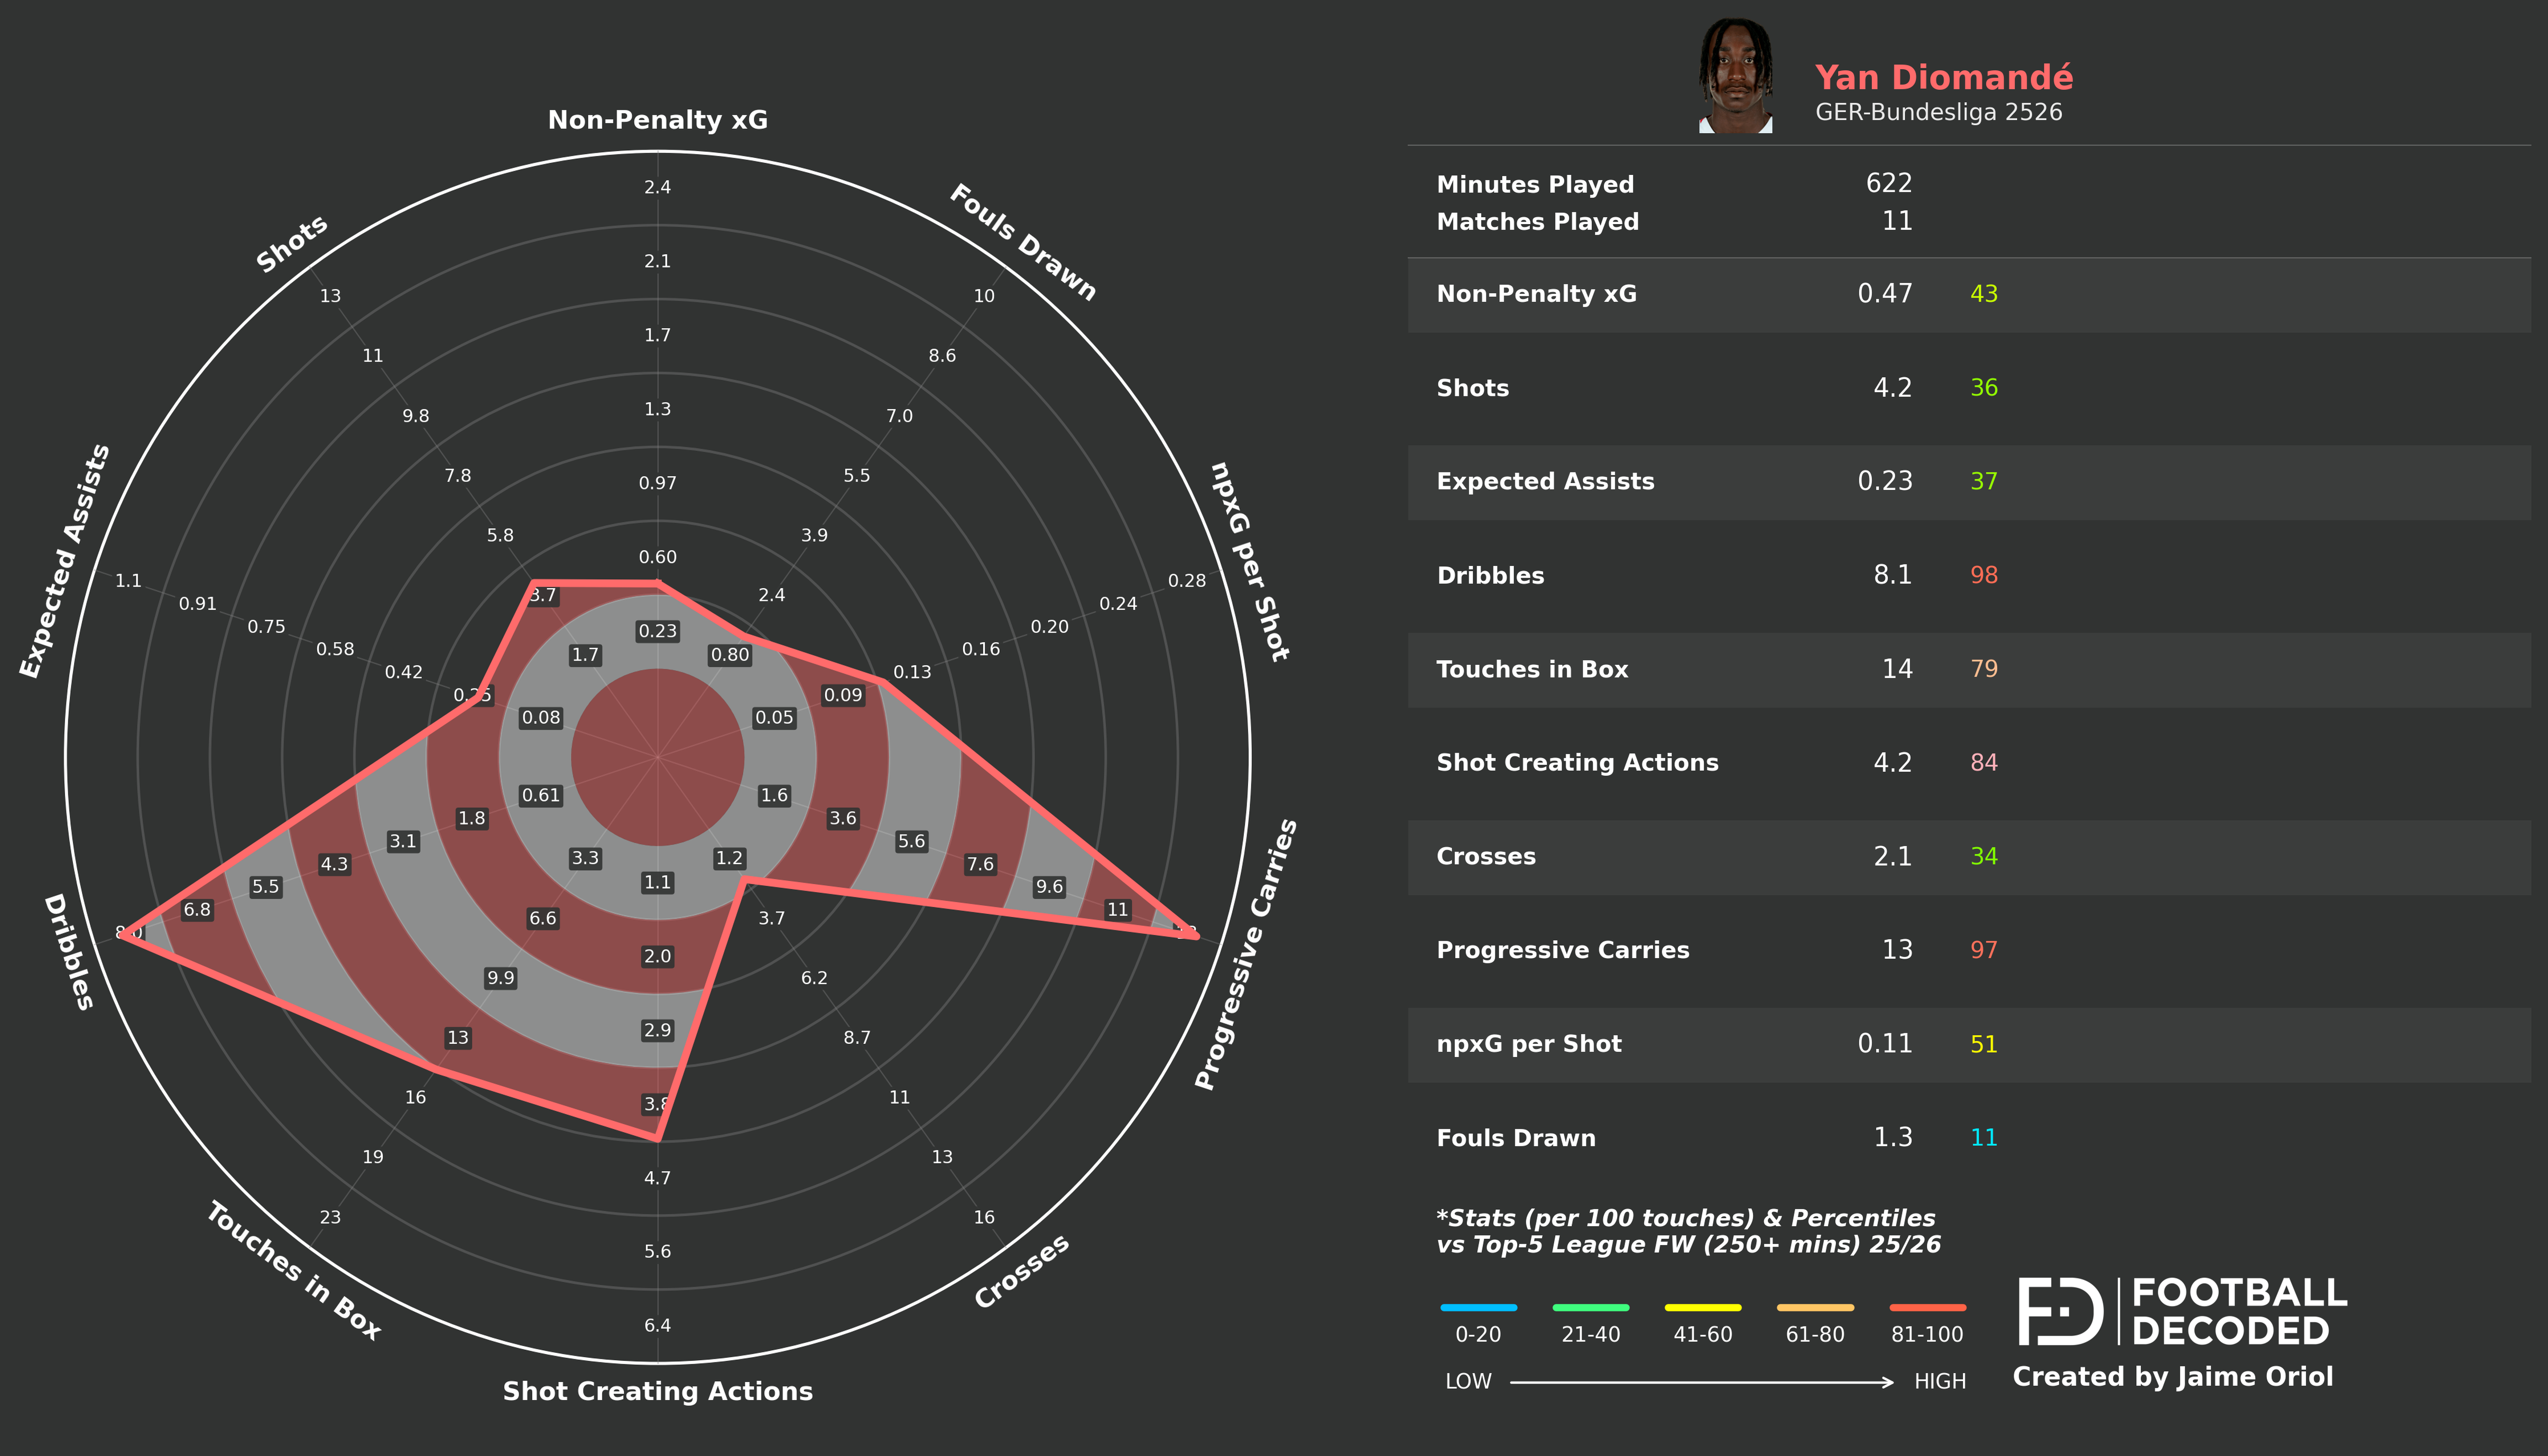

In [11]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

if diomande_id:
    print("GENERATING DIOMANDÉ RADAR")
    print("=" * 60)
    
    # Team logos
    team_logos = {diomande_team: '/home/jaime/FD/data/blog/caras/diomande.png'}
    
    try:
        # Radar
        create_player_radar(
            df_data=df_final,
            player_1_id=diomande_id,
            player_2_id=None,
            metrics=extremo_metrics,
            metric_titles=extremo_titles,
            team_colors=[LEIPZIG_COLORS['primary'], LEIPZIG_COLORS['secondary']],
            save_path=f"{SAVE_PATH_BASE}diomande_radar.png",
            use_swarm=False,
            show_plot=False
        )
        print("✓ Radar generado")
        
        # Tabla
        create_stats_table(
            df_data=df_final,
            player_1_id=diomande_id,
            player_2_id=None,
            metrics=extremo_metrics,
            metric_titles=extremo_titles,
            team_colors=[LEIPZIG_COLORS['primary'], LEIPZIG_COLORS['secondary']],
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}diomande_table.png",
            footer_text=f"Stats (per 100 touches) & Percentiles\nvs Top-5 League FW ({MIN_MINUTES}+ mins) 25/26",
            show_plot=False
        )
        print("✓ Tabla generada")
        
        # Combinar
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}diomande_radar.png",
            table_path=f"{SAVE_PATH_BASE}diomande_table.png",
            output_path=f"{SAVE_PATH_BASE}diomande_combined.png"
        )
        print(f"✓ Combined: {SAVE_PATH_BASE}diomande_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}diomande_combined.png"))
        
    except Exception as e:
        print(f"✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    print("✗ No se puede generar radar")